In [1]:
from typing import Optional, Tuple, Union, List
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import math
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import optim
import torchvision
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [2]:
class DiffusionForwardProcess:

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # khởi tạo beta, alpha,....
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)

    def add_noise(self, original, noise, t):

        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]

        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]

        return (sqrt_alpha_bar_t * original + sqrt_one_minus_alpha_bar_t * noise)

In [3]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,))

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

In [4]:
class DiffusionReverseProcess:

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Tính a, b theo từng time_step
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar

    def sample_prev_timestep(self, xt, noise_pred, t):

        # Dự đoán x0 theo từng time_step
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.)

        # mean of x_(t-1)
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))

        # nếu t = 0 thì chỉ lấy mean
        if t == 0:
            return mean, x0

        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)

            return mean + sigma * z, x0

In [5]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,))

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

In [6]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int):

    factor = 2 * torch.arange(start = 0,
                              end = t_emb_dim//2,
                              dtype=torch.float32,
                              device=time_steps.device
                             ) / (t_emb_dim)
    factor = 10000**factor
    t_emb = time_steps[:,None]
    t_emb = t_emb/factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1)

    return t_emb

In [7]:
class NormActConv(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 num_groups:int = 8,
                 kernel_size: int = 3,
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()

        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()

        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1)//2
        )

    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

class TimeEmbedding(nn.Module):

    def __init__(self,
                 n_out:int,
                 t_emb_dim:int = 128
                ):
        super(TimeEmbedding, self).__init__()

        self.te_block = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, n_out)
        )

    def forward(self, x):
        return self.te_block(x)

class SelfAttentionBlock(nn.Module):

    def __init__(self,
                 num_channels:int,
                 num_groups:int = 8,
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()

        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads,
            batch_first=True
        )

    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x


class Downsample(nn.Module):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2,
                 use_conv:bool = True,
                 use_mpool:bool = True
                ):
        super(Downsample, self).__init__()

        self.use_conv = use_conv
        self.use_mpool = use_mpool

        # using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_mpool else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            )
        ) if use_conv else nn.Identity()

        # using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_mpool else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.mpool(x)

        if not self.use_mpool:
            return self.cv(x)

        return torch.cat([self.cv(x), self.mpool(x)], dim=1)


class Upsample(nn.Module):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2,
                 use_conv:bool = True,
                 use_upsample:bool = True
                ):
        super(Upsample, self).__init__()

        self.use_conv = use_conv
        self.use_upsample = use_upsample

        #using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size = 1,
                stride=1,
                padding=0
            )
        ) if use_conv else nn.Identity()

        # using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k,
                mode = 'bilinear',
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_upsample else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.up(x)

        if not self.use_upsample:
            return self.cv(x)

        return torch.cat([self.cv(x), self.up(x)], dim=1)

In [8]:
layer = Upsample(16, 32, 2, True, True)
x = torch.randn(4, 16, 32, 32)
layer(x).shape

torch.Size([4, 32, 64, 64])

In [9]:
class DownC(nn.Module):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding
                 num_layers:int=2,
                 down_sample:bool = True
                ):
        super(DownC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, t_emb):

        out = x

        for i in range(self.num_layers):
            resnet_input = out

            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)
            #attn
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        out = self.down_block(out)

        return out

In [10]:
class MidC(nn.Module):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers + 1)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x

        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)

        # Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            out_attn = self.attn_block[i](out)
            out = out + out_attn

            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)

        return out

In [11]:
class UpC(nn.Module):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2,
                 up_sample:bool = True
                ):
        super(UpC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, down_out, t_emb):

        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            out_attn = self.attn_block[i](out)
            out = out + out_attn

        return out

In [12]:
class Unet(nn.Module):

    def __init__(self,
                 im_channels: int = 1, # RGB
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2,
                 num_midc_layers:int = 2,
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()

        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers

        self.up_sample = list(reversed(self.down_sample))

        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)

        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i],
                self.down_ch[i+1],
                self.t_emb_dim,
                self.num_downc_layers,
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])

        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i],
                self.mid_ch[i+1],
                self.t_emb_dim,
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])

        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i],
                self.up_ch[i+1],
                self.t_emb_dim,
                self.num_upc_layers,
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])

        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]),
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):

        out = self.cv1(x)

        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        down_outs = []

        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        out = self.cv2(out)

        return out

In [13]:
# Test
model = Unet()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape

torch.Size([4, 1, 32, 32])

In [14]:
class CONFIG:
    model_path = 'ddpm_unet.pth'
    num_epochs = 5
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_img_to_generate = 64

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Dataset và Dataloader cho MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh về phạm vi [-1, 1]
])




In [16]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(cfg):

    # Sử dụng MNIST từ torchvision
    mnist_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Tạo DataLoader
    mnist_dl = DataLoader(mnist_ds, batch_size=cfg.batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')

    # Initiate Model
    model = Unet().to(device)

    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()

    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()

    # Best Loss
    best_eval_loss = float('inf')

    # Train
    for epoch in range(cfg.num_epochs):

        # For Loss Tracking
        losses = []

        # Set model to train mode
        model.train()

        # Loop over dataloader
        for imgs, labels in tqdm(mnist_dl):
            # Chuyển ảnh vào device
            imgs = imgs.to(device)
            labels = labels.to(device)
            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)

            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)

            # Avoid Gradient Accumulation
            optimizer.zero_grad()

            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)

            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())

            # Backprop + Update model params
            loss.backward()
            optimizer.step()

        # Mean Loss
        mean_epoch_loss = np.mean(losses)

        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))

        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            torch.save(model, cfg.model_path)

    print(f'Done training.....')

In [17]:
# Config
cfg = CONFIG()

train(cfg)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


Device: cuda



100%|██████████| 469/469 [05:24<00:00,  1.45it/s]


Epoch:1 | Loss : 0.1577


100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch:2 | Loss : 0.0535


100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch:3 | Loss : 0.0417


100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch:4 | Loss : 0.0362


100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch:5 | Loss : 0.0332
Done training.....


In [18]:
def generate(cfg):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    drp = DiffusionReverseProcess()

    # eval mode
    model = torch.load(cfg.model_path, weights_only=False).to(device)
    model.eval()

    # Generate Noise
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)

    # Denoise
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2

    return xt

100%|██████████| 64/64 [20:52<00:00, 19.57s/it]


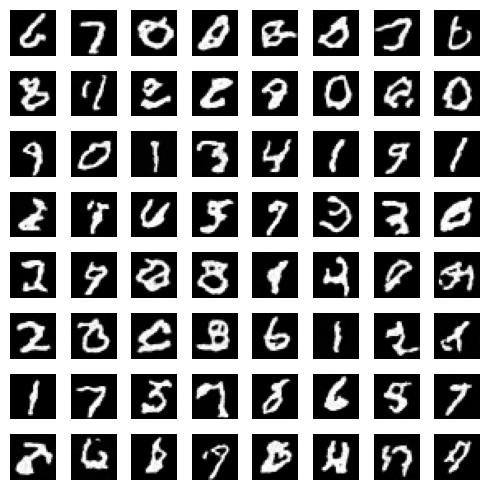

In [19]:

# Generate
generated_imgs = []
for i in tqdm(range(cfg.num_img_to_generate)):
    xt = generate(cfg)
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())


# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

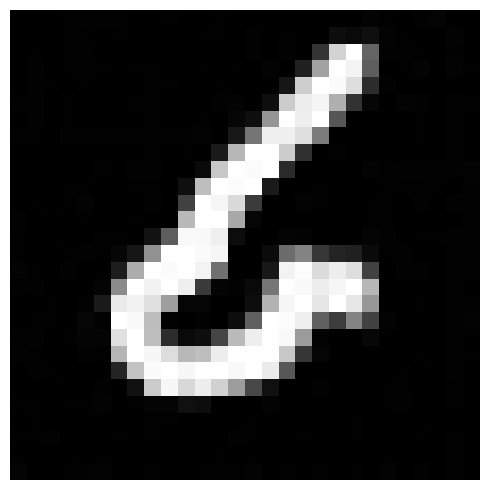

In [20]:
# Visualize
from matplotlib import pyplot as plt

# Tạo một subplot với 1 ảnh duy nhất
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Vẽ ảnh đầu tiên
ax.imshow(np.reshape(generated_imgs[0], (28, 28)), cmap='gray')
ax.axis('off')  # Tắt các trục

plt.tight_layout()
plt.show()
